In [1]:
import numpy as np

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary
from torch import nn
import torch.nn
from torch.functional import F

from tqdm import tqdm
import torch.optim as optim


import matplotlib.pyplot as plt
import os

os.chdir('d:\Python Projects\EVA')

In [2]:
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),(0.3081,))
                                      ])


test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),(0.3081,))
                                      ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data',train=False, download=True, transform=test_transforms)


In [4]:
#
SEED = 1

device = 'cuda' if torch.cuda else 'cpu'
print(device)

# for Reproducable results
torch.manual_seed(SEED)

#Setting seed if CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Dataloader Arguments
dataloader_args = dict(shuffle=True, num_workers=4, batch_size=128, pin_memory=True) if torch.cuda.is_available() else dict(shuffle=True, batch_size=64)

train_dataloader = DataLoader(train,**dataloader_args)

test_dataloader = DataLoader(test, **dataloader_args)  

cuda


D:\Python\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


 - Shape  (60000, 28, 28)
 - Max  tensor(2.8215)
 - Min  tensor(-0.4242)
 - Mean  tensor(-0.0001)
 - Std dev  tensor(1.0000)
 - Var  tensor(1.0001)


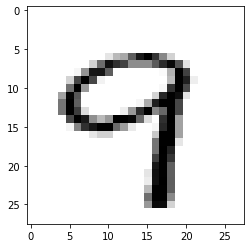

In [5]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print(' - Shape ', train.train_data.cpu().numpy().shape)
print(' - Max ', torch.max(train_data))
print(' - Min ', torch.min(train_data))
print(' - Mean ',torch.mean(train_data))
print(' - Std dev ', torch.std(train_data))
print(' - Var ', torch.var(train_data))

# Displaying images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

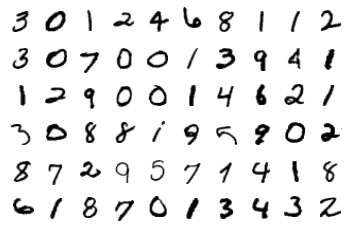

In [6]:
#Plot bunch of images
figure = plt.figure()
NUM_IMAGES = 60

for index in range(1,NUM_IMAGES+1):
    plt.subplot(6,10,index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')


# The Model

In [7]:

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3,padding=1),  # 28
            nn.ReLU(),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),  # 28
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),  # 14
            nn.ReLU(),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),  # 14
            nn.ReLU(),
            nn.MaxPool2d(2,2),  # 7
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, 3),  # 5
            nn.ReLU(),
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 1024, 3),  #3
            nn.ReLU(),
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(1024, 10, 3),  #1
        )

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = x.view(-1,10)
        return F.log_softmax(x, dim=-1)


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 28, 28]          18,496
              ReLU-4           [-1, 64, 28, 28]               0
         MaxPool2d-5           [-1, 64, 14, 14]               0
            Conv2d-6          [-1, 128, 14, 14]          73,856
              ReLU-7          [-1, 128, 14, 14]               0
            Conv2d-8          [-1, 256, 14, 14]         295,168
              ReLU-9          [-1, 256, 14, 14]               0
        MaxPool2d-10            [-1, 256, 7, 7]               0
           Conv2d-11            [-1, 512, 5, 5]       1,180,160
             ReLU-12            [-1, 512, 5, 5]               0
           Conv2d-13           [-1, 1024, 3, 3]       4,719,616
             ReLU-14           [-1, 102

In [9]:
train_acc = []
test_acc = []
train_losses = []
test_losses = []

def train(model, device, train_dataloader, optimizer, epochs):
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)



def test(model, device, test_dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():

        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20

for epoch in range(EPOCHS):
    print('EPOCH - ', epoch)
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

EPOCH -  0


Loss=0.05259384587407112 Batch_id=468 Accuracy=86.30: 100%|██████████████████████████| 469/469 [00:32<00:00, 14.26it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0571, Accuracy: 9821/10000 (98.21%)

EPOCH -  1


Loss=0.02828935533761978 Batch_id=468 Accuracy=98.31: 100%|██████████████████████████| 469/469 [00:32<00:00, 14.51it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9873/10000 (98.73%)

EPOCH -  2


Loss=0.039922136813402176 Batch_id=468 Accuracy=98.92: 100%|█████████████████████████| 469/469 [00:33<00:00, 13.87it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9895/10000 (98.95%)

EPOCH -  3


Loss=0.023973951116204262 Batch_id=468 Accuracy=99.21: 100%|█████████████████████████| 469/469 [00:27<00:00, 16.92it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9905/10000 (99.05%)

EPOCH -  4


Loss=0.06263499706983566 Batch_id=468 Accuracy=99.46: 100%|██████████████████████████| 469/469 [00:28<00:00, 16.19it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9914/10000 (99.14%)

EPOCH -  5


Loss=0.005843097809702158 Batch_id=468 Accuracy=99.54: 100%|█████████████████████████| 469/469 [00:27<00:00, 16.77it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9908/10000 (99.08%)

EPOCH -  6


Loss=0.0013131102314218879 Batch_id=468 Accuracy=99.66: 100%|████████████████████████| 469/469 [00:27<00:00, 17.01it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9914/10000 (99.14%)

EPOCH -  7


Loss=0.033662259578704834 Batch_id=468 Accuracy=99.72: 100%|█████████████████████████| 469/469 [00:27<00:00, 17.04it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9917/10000 (99.17%)

EPOCH -  8


Loss=0.000951359688770026 Batch_id=468 Accuracy=99.78: 100%|█████████████████████████| 469/469 [00:27<00:00, 17.07it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9918/10000 (99.18%)

EPOCH -  9


Loss=0.0011422733077779412 Batch_id=468 Accuracy=99.84: 100%|████████████████████████| 469/469 [00:27<00:00, 16.77it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9923/10000 (99.23%)

EPOCH -  10


Loss=0.004385699983686209 Batch_id=468 Accuracy=99.90: 100%|█████████████████████████| 469/469 [00:27<00:00, 16.78it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9919/10000 (99.19%)

EPOCH -  11


Loss=0.007184068206697702 Batch_id=468 Accuracy=99.89: 100%|█████████████████████████| 469/469 [00:28<00:00, 16.70it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9922/10000 (99.22%)

EPOCH -  12


Loss=0.0001385211944580078 Batch_id=468 Accuracy=99.88: 100%|████████████████████████| 469/469 [00:28<00:00, 16.69it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9931/10000 (99.31%)

EPOCH -  13


Loss=0.000437597424024716 Batch_id=468 Accuracy=99.97: 100%|█████████████████████████| 469/469 [00:27<00:00, 16.78it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9926/10000 (99.26%)

EPOCH -  14


Loss=0.022255659103393555 Batch_id=468 Accuracy=99.90: 100%|█████████████████████████| 469/469 [00:27<00:00, 16.80it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9900/10000 (99.00%)

EPOCH -  15


Loss=0.00012979905295651406 Batch_id=468 Accuracy=99.93: 100%|███████████████████████| 469/469 [00:28<00:00, 16.74it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9928/10000 (99.28%)

EPOCH -  16


Loss=0.00013410051178652793 Batch_id=468 Accuracy=99.99: 100%|███████████████████████| 469/469 [00:27<00:00, 16.98it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9926/10000 (99.26%)

EPOCH -  17


Loss=9.232759475708008e-05 Batch_id=468 Accuracy=99.99: 100%|████████████████████████| 469/469 [00:27<00:00, 16.92it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9925/10000 (99.25%)

EPOCH -  18


Loss=0.00013557076454162598 Batch_id=468 Accuracy=100.00: 100%|██████████████████████| 469/469 [00:28<00:00, 16.71it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9927/10000 (99.27%)

EPOCH -  19


Loss=3.459056097199209e-05 Batch_id=468 Accuracy=100.00: 100%|███████████████████████| 469/469 [00:28<00:00, 16.64it/s]



Test set: Average loss: 0.0318, Accuracy: 9928/10000 (99.28%)



Text(0.5, 1.0, 'Test Accuracy')

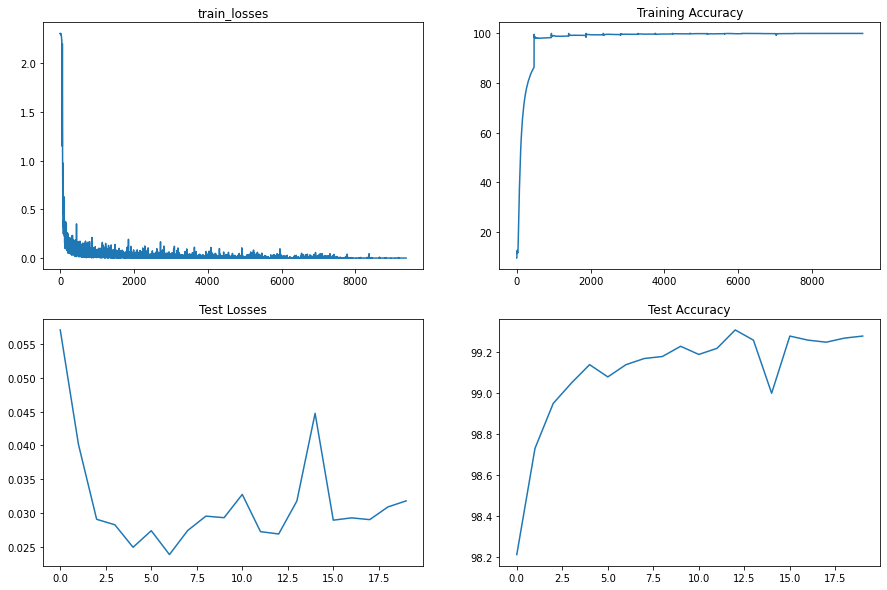

In [11]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0,0].plot(train_losses)
axs[0,0].set_title('train_losses')
axs[0,1].plot(train_acc)
axs[0,1].set_title('Training Accuracy')
axs[1,0].plot(test_losses)
axs[1,0].set_title('Test Losses')
axs[1,1].plot(test_acc)
axs[1,1].set_title('Test Accuracy')